In [4]:
# from ipyparallel import Client
# rc = Client()

In [2]:
# rc.ids

[0, 1, 2, 3, 4, 5]

In [1]:
# %%px
import SAME_ECOS_functions as se
import time
import numpy as np
import scipy.io as sio
import math
import itertools

In [31]:
pwd

'/export01/data/Hanwen/SAME-ECOS'

In [3]:
EPG_decay_lib = se.load_decay_lib('/export01/data/Hanwen/SAME-ECOS/EPG_decay_library.mat')

In [4]:
data = se.mp_yield_training_data(se.produce_training_data,
                                 EPG_decay_lib,
                                 realizations=5000000,
                                 ncores=12,
                                 SNR_boundary_low=50,
                                 SNR_boundary_high=800,
                                 echo_3=30,
                                 echo_last=320,
                                 echo_train_num=32,
                                 num_t2_basis=40,
                                 FA_min=50,
                                 peak_width=1,
                                 T2_min_universal=None,
                                 T2_max_universal=None,
                                 exclude_M_max=False,
                                 )

In [5]:
data.keys()

dict_keys(['T2_location', 'T2_amplitude', 'decay_curve', 'decay_curve_with_noise', 'train_label', 'train_label_gaussian', 'num_T2_SNR_FA'])

In [6]:
import time
import datetime

In [7]:
import tensorflow as tf
import sklearn.metrics as metrics
import keras
from keras import regularizers

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
y = data['train_label_gaussian']
y.shape

(5000000, 40)

In [10]:
x = data['decay_curve_with_noise']
x.shape

(5000000, 32)

In [11]:
## normalization to the first echo
x=x/x[:,0].reshape(x.shape[0],1) 

In [12]:
t2_basis = se.t2_basis_generator(5,2000,40)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=10)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=10)

In [15]:
print('training x: '+ str(x_train.shape))
print('traing y: '+ str(y_train.shape))
print('validation x: '+ str(x_val.shape))
print('validation y: '+ str(y_val.shape))
print('testing x: '+ str(x_test.shape))
print('testing y: '+ str(y_test.shape))

training x: (4050000, 32)
traing y: (4050000, 40)
validation x: (450000, 32)
validation y: (450000, 40)
testing x: (500000, 32)
testing y: (500000, 40)


In [16]:
hidden_layers=[100, 500, 1000, 1000, 500] 
acti='selu'
initial='lecun_normal'
Batch_norm = 'yes'
selected_optimizer = keras.optimizers.Adamax(lr=0.005)
#loss_function = 'cosine_similarity'
loss_function = 'categorical_crossentropy'
#loss_function = 'mean_squared_error'
l1_strength = 0.1
l2_strength = 0.1
metrics=[tf.keras.metrics.CosineSimilarity(axis=-1)]

In [79]:
f = open("NN_training.txt", "a")
now = datetime.datetime.now()
f.write("Date and Time: {} \n".format(now.strftime("%Y-%m-%d %H:%M:%S")))
f.write('selected hidden layer structure = {} \n'.format(hidden_layers))
f.write('activation = {}, initialization = {} \n'.format(acti, initial))
f.write('Batch_norm = {}, loss_function = {}, regularization_strength = {},\nselected_optimizer = {} \n \n \n'.format(Batch_norm, loss_function, l2_strength, selected_optimizer))

keras.backend.clear_session()
model = keras.Sequential()
model.add(keras.layers.BatchNormalization())
for nodes in hidden_layers:
    model.add(keras.layers.Dense(nodes, kernel_initializer=initial, activation=acti))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(40, kernel_initializer=initial, activation='softmax', activity_regularizer=regularizers.l1_l2(l1=l1_strength, l2=l2_strength)))
    
model.compile(optimizer=keras.optimizers.Adamax(lr=0.005), loss=loss_function, metrics=[tf.keras.metrics.CosineSimilarity(axis=-1)])
            
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_cosine_similarity',patience=15),
                  #keras.callbacks.ModelCheckpoint(filepath='pre-trained_model_no_noise.h5',monitor='val_cosine_similarity',save_best_only=True,),
                  keras.callbacks.ReduceLROnPlateau(monitor='cosine_similarity',factor=0.5,patience=3)]
            
start_time = time.time()
history = model.fit(x_train, y_train, epochs=40, batch_size=256, callbacks=callbacks_list, validation_data=(x_val, y_val))

print("--- %.2f seconds ---" % (time.time() - start_time))
f.write("--- Training time %.2f seconds --- \n" % (time.time() - start_time))
print('training stopped at epoch = {}'.format(len(history.history['lr'])))
f.write('training stopped at epoch = {} \n \n'.format(len(history.history['lr'])))
f.write('validation similarity = {} \n \n'.format(list(round(i,4) for i in history.history['val_cosine_similarity'])))
f.write('learning rate = {} \n \n'.format(list(round(i,6) for i in history.history['lr'])))

NN_predict = model.predict(x_test)
print('Similarity for the whole test set = {}'.format(cosine_similarity(NN_predict[:,:].reshape(1,-1), y_test[:,:].reshape(1,-1))))
f.write('Similarity for the whole test set = {} \n'.format(cosine_similarity(NN_predict[:,:].reshape(1,-1), y_test[:,:].reshape(1,-1))))

similarity_score = np.zeros((y_test.shape[0],1))
#for item in range(1):
for item in range(y_test.shape[0]):
    similarity_score[item,:] = cosine_similarity(NN_predict[item,:].reshape(1, -1), y_test[item,:].reshape(1, -1))
print('Average similarity for each spectrum in the test set = {} +/- {} \n'.format(similarity_score.mean(), similarity_score.std()))
f.write('Average similarity for each spectrum in the test set = {} +/- {} \n'.format(similarity_score.mean(), similarity_score.std()))           
f.write('#############################################\n')
f.write('\n \n')
f.close()

Epoch 1/40
15821/15821 [==============================] - 175s 11ms/step - loss: 2.8723 - cosine_similarity: 0.7608 - val_loss: 2.8152 - val_cosine_similarity: 0.7807
Epoch 2/40
15821/15821 [==============================] - 174s 11ms/step - loss: 2.7643 - cosine_similarity: 0.8018 - val_loss: 2.9326 - val_cosine_similarity: 0.7345
Epoch 3/40
15821/15821 [==============================] - 175s 11ms/step - loss: 2.7471 - cosine_similarity: 0.8088 - val_loss: 2.8427 - val_cosine_similarity: 0.7722
Epoch 4/40
15821/15821 [==============================] - 175s 11ms/step - loss: 2.7352 - cosine_similarity: 0.8137 - val_loss: 2.7804 - val_cosine_similarity: 0.7987
Epoch 5/40
15821/15821 [==============================] - 175s 11ms/step - loss: 2.7145 - cosine_similarity: 0.8227 - val_loss: 2.8046 - val_cosine_similarity: 0.7876
Epoch 6/40
15821/15821 [==============================] - 175s 11ms/step - loss: 2.7054 - cosine_similarity: 0.8265 - val_loss: 2.7844 - val_cosine_similarity: 0.793

In [88]:
#model.save('NN_trained_model_gaussian_v3.h5')

In [18]:
import matplotlib.pyplot as plt

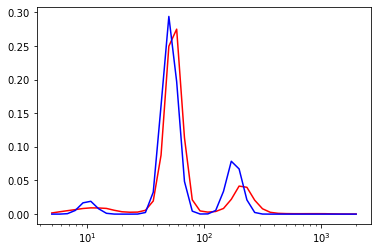

[0.92848145]


In [80]:
i = 2001
plt.plot(t2_basis, NN_predict[i,:],'r')
plt.plot(t2_basis, y_test[i,:],'b')
plt.xscale('log')
plt.show()
print(similarity_score[i])

In [34]:
import nibabel as nib

In [39]:
file_path = '/export01/data/Hanwen/data/mcgrase_data/In-vivo/da_001_tardif_20171108_133651/convert/mcgrase_32e.mnc'
img = nib.load(file_path)
img_data = img.get_fdata()

In [41]:
img_data = np.swapaxes(img_data,0,3)
img_data = np.swapaxes(img_data,1,2)
img_data = np.swapaxes(img_data,0,1)
img_data.shape

(128, 128, 16, 32)

In [53]:
import importlib
importlib.reload(se)

<module 'SAME_ECOS_functions' from '/export01/data/Hanwen/SAME-ECOS/SAME_ECOS_functions.py'>

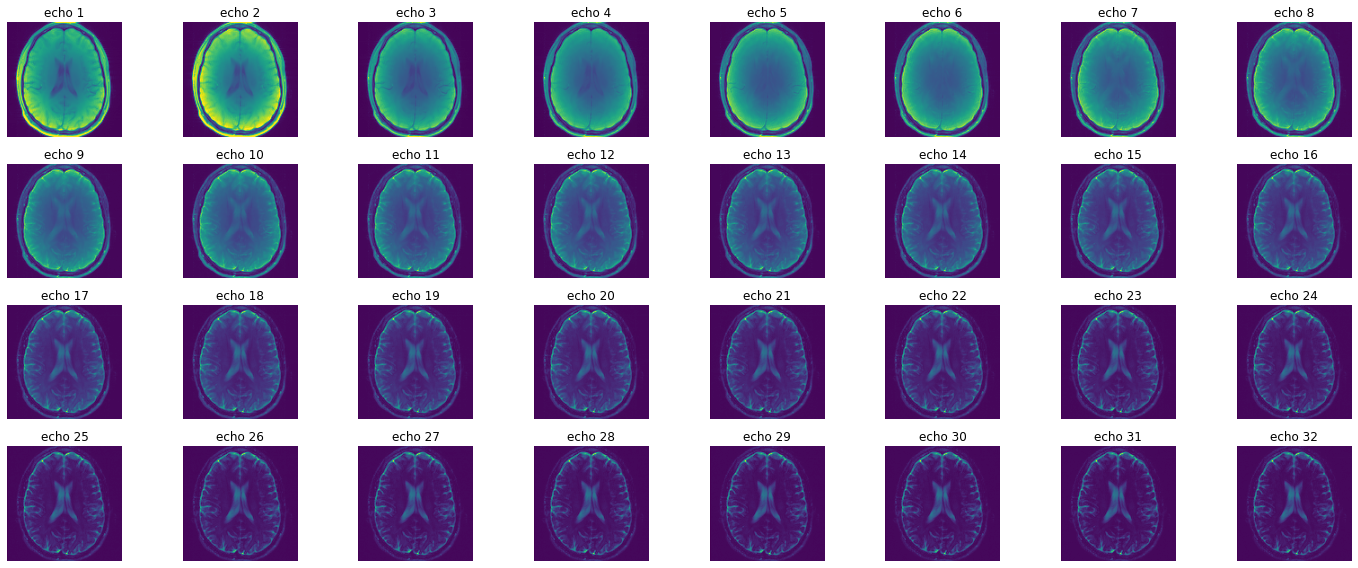

In [54]:
se.plot_all_echoes(img_data, slice_num=8, rows=4, columns=8, fig_size=(20,8), tight=True)

In [81]:
NN_predict_spectrum = se.NN_predict_4D_decay(img_data, model)

/export01/data/Hanwen/SAME-ECOS/SAME_ECOS_functions.py:635: RuntimeWarning: invalid value encountered in true_divide
  decay_flat_norm = decay_flat / (decay_flat[:, 0].reshape(


In [82]:
NN_predict_spectrum.shape

(128, 128, 16, 40)

In [83]:
NN_predict_metrics = se.quantitative_map_production(t2_basis,
                                                    NN_predict_spectrum,
                                                    MW_low_cutoff=0,
                                                    MW_high_cutoff=40,
                                                    IEW_low_cutoff=40,
                                                    IEW_high_cutoff=200)

In [68]:
NN_predict_metrics.shape

(128, 128, 16, 5)

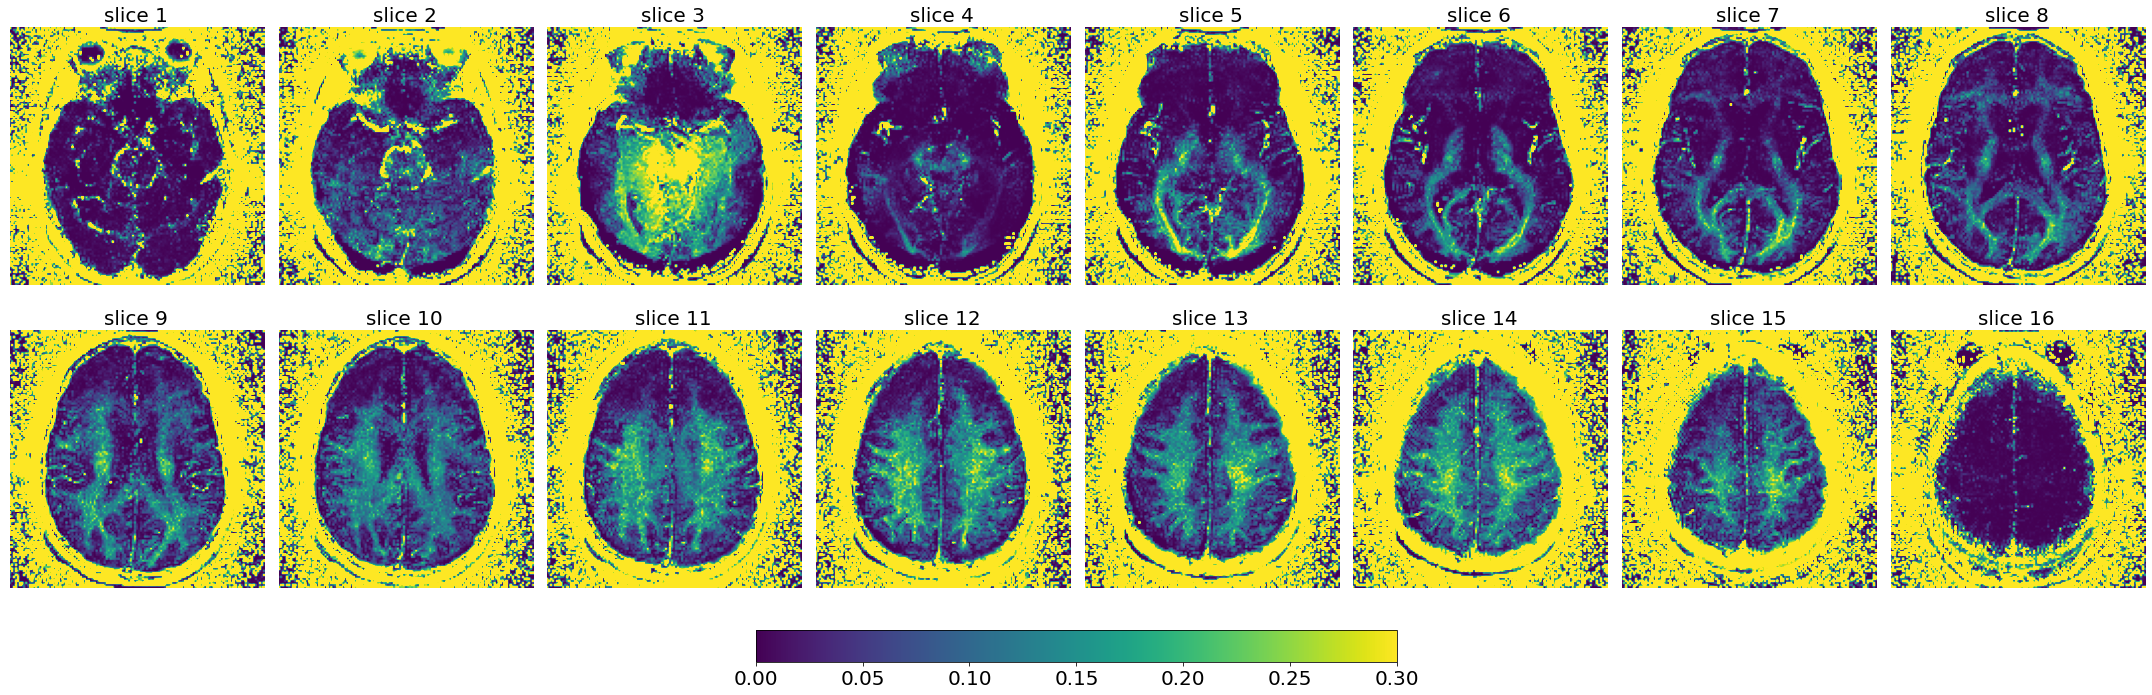

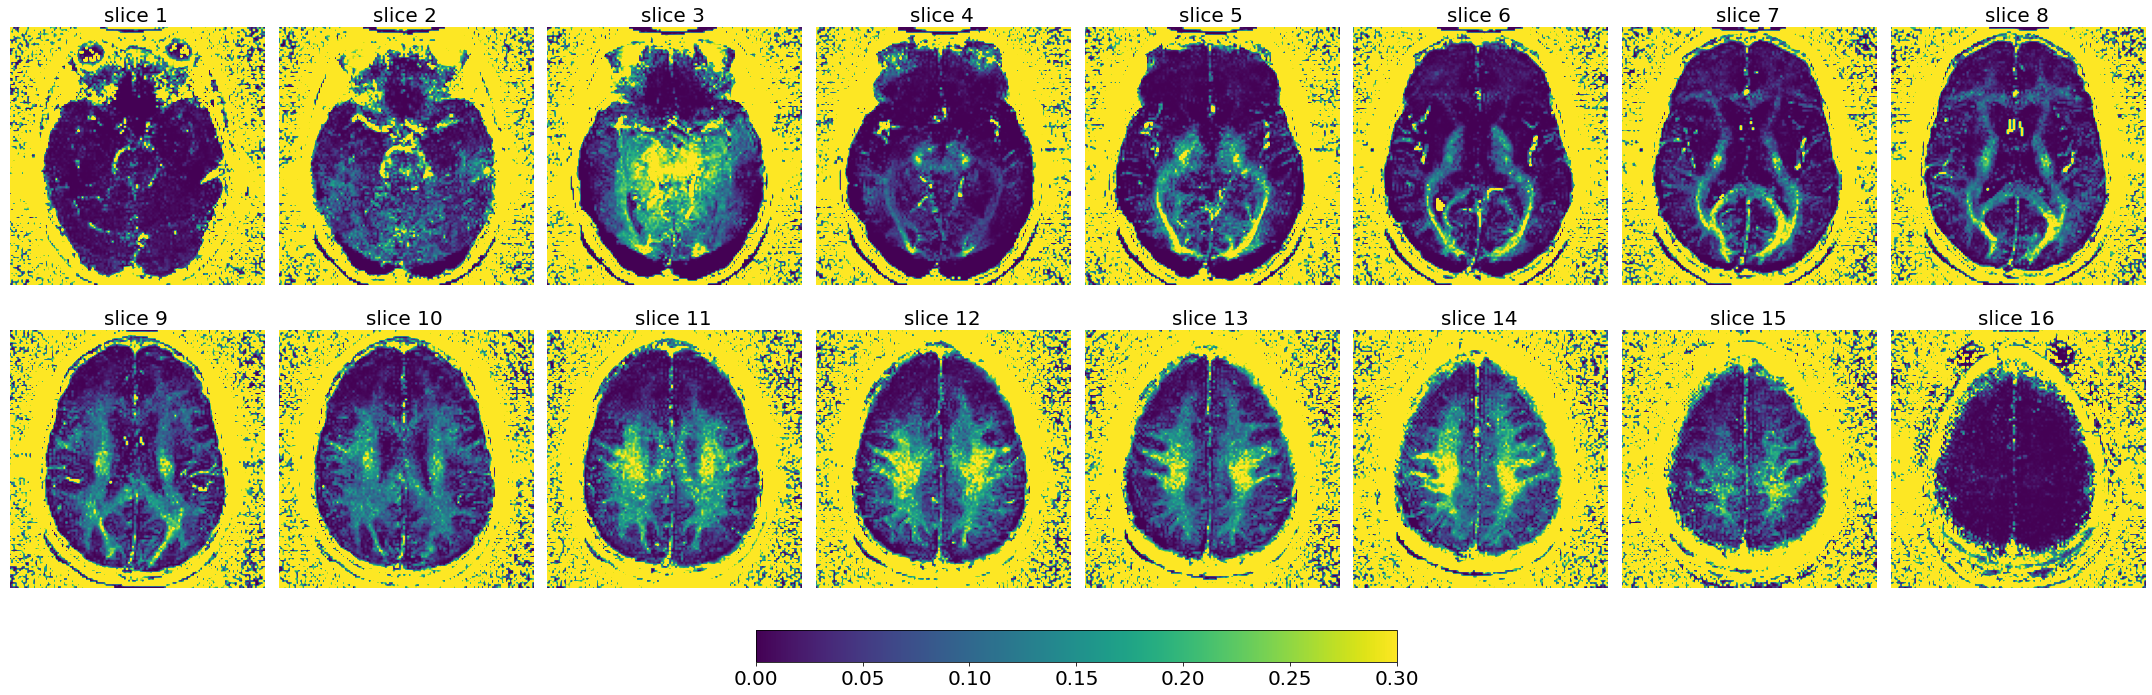

In [87]:
se.plot_maps_slice(NN_predict_metrics[:,:,:,0], nrow=2, ncol=8, vmin=0, vmax=0.3)

In [7]:
#%%px
### Record simulation time
#start_time = time.time()

### Number of realizations
realizations = 1000

### Experimental and analysis parameters
SNR_boundary_low = 50
SNR_boundary_high = 800
echo_3 = 30
echo_last = 320 
echo_train_num = 32
num_t2_basis = 40
FA_min = 50
MW_low_cutoff = 0
MW_high_cutoff = 40
IEW_low_cutoff = 40
IEW_high_cutoff = 200

### load EPG decay data table (provided)
EPG_decay_lib = se.load_decay_lib('/export01/data/Hanwen/SAME-ECOS/EPG_decay_library.mat')

### Define T2 range, maximum number (M_max) of T2 peaks at the highest SNR, allowable number (N) of T2 peaks for simulation 
T2_min_universal,_ = se.T2_boundary(SNR_boundary_high, echo_3, echo_last) ## Lower boundary is determined by the highest SNR
T2_max_universal = 2000 ## empirically determined
t2_basis = se.t2_basis_generator(T2_min_universal, T2_max_universal, num_t2_basis)
M_max = int(np.floor(se.T2_components_resolution_finite_domain(SNR_boundary_high, T2_min_universal, T2_max_universal))) ## M at highest SNR
resolution_max = se.resloution_limit(T2_min_universal, T2_max_universal, M_max) ## resolution at highest SNR
N = M_max ## for simulation M_max is excluded

### Create placeholders for memory efficiency
num_T2_all = np.zeros([realizations, 1])
T2_location_all = np.zeros([realizations, N])
T2_amplitude_all = np.zeros([realizations,N])
decay_curve_all = np.zeros([realizations, echo_train_num])
decay_curve_with_noise_all = np.zeros([realizations, echo_train_num])
train_label_all = np.zeros([realizations,num_t2_basis])
train_label_gaussian_all = np.zeros([realizations,num_t2_basis])
metrics_all = np.zeros([realizations,7])
metrics_all_GT = np.zeros([realizations,7])

#num_T2_list=[]

### For each realization
for i in range(realizations):        
    ### Randomly determine the SNR, the minimum T2, the number of T2s (must < M), and the flip angle FA.
    #SNR = 100 ## for fixed SNR
    SNR = np.random.randint(SNR_boundary_low, SNR_boundary_high)
    T2_min, _ = se.T2_boundary(SNR, echo_3, echo_last)
    T2_max = T2_max_universal
    M = np.floor(se.T2_components_resolution_finite_domain(SNR, T2_min, T2_max))
    N_choice = np.arange(1, M+1)
    weight = N_choice**0.01 ## weighting factor for each choice
    num_T2 = int(np.random.choice(N_choice, p=weight/weight.sum()))
    #num_T2_list.append(num_T2)

    FA = np.random.randint(FA_min, 180+1)
    #print(num_T2)
    
    ### Calculate the resolution limit
    resolution = se.resloution_limit(T2_min, T2_max, M)

    ### Randomly generate T2 peak location, regenerate the T2 location if the resolution limit is broken.
    #T2_location = T2_location_generator_v3(T2_min, T2_max, num_T2, num_t2_basis, resolution, log_cutoff=10, smooth=False)
    T2_location = se.T2_location_generator_v3(T2_min, T2_max, num_T2, M_max, scale='log')
    while se.T2_resolution_examiner(T2_location, resolution) == False:
        T2_location = se.T2_location_generator_v3(T2_min, T2_max, num_T2, M_max, scale='log')    
    ### Randomly generate T2 peak amplitude. When two or more peaks, minimal detectable amplitude is calculated
    if num_T2==1:
        T2_amplitude = np.array([1.0])
    else: 
        ratio_min , frequency = se.required_frequency(T2_location)
        minimum_amplitude = se.minimum_amplitude_calculator(SNR, frequency)
        T2_amplitude = se.T2_amplitude_generator_v3(num_T2, minimum_amplitude)
    
    #print(T2_location, ratio_min, T2_amplitude, minimum_amplitude)
    
    ### Decay curve generation (weighted sum of each T2 component)
    decay_curve = se.produce_decay_from_lib(EPG_decay_lib, T2_location, T2_amplitude, FA)
    
    ### Add noise to decay curve
    decay_curve_with_noise = se.signal_with_noise_generation_phase_rotation(signal=decay_curve, SNR=SNR)
    
    ### T2 basis set embedding (nearest t2_basis neighbors)
    train_label = se.train_label_generator(T2_location, T2_amplitude, t2_basis)
    
    ### T2 basis set embedding (gaussian peaks)
    train_label_gaussian = se.train_label_generator_gaussian_embedding(T2_location, T2_amplitude, T2_min_universal, T2_max_universal, t2_basis, sigma=1)
    
    ### Extract metrics (use t2_basis and train label instead of T2_location and T2_amplitude to prevent basis set embedding error)
    MWF, MWGMT2, IEWF, IEWGMT2, GMT2 = se.metrics_extraction_v3(t2_basis, train_label, MW_low_cutoff, MW_high_cutoff, IEW_low_cutoff, IEW_high_cutoff)
    
    ### Ground truth metrics (use tT2_location and T2_amplitude)
    MWF_GT, MWGMT2_GT, IEWF_GT, IEWGMT2_GT, GMT2_GT = se.metrics_extraction_v3(T2_location, T2_amplitude, MW_low_cutoff, MW_high_cutoff, IEW_low_cutoff, IEW_high_cutoff)
    
    ### Pad T2_location and T2_amplitude to have uniform size
    T2_location = np.pad(T2_location,[(0, N-int(num_T2))], mode='constant', constant_values=0)
    T2_amplitude = np.pad(T2_amplitude,[(0, N-int(num_T2))], mode='constant', constant_values=0)   
    
    ### Store generated parameters in placeholders
    num_T2_all[i,:] = num_T2
    T2_location_all[i,:] = T2_location
    T2_amplitude_all[i,:] = T2_amplitude 
    decay_curve_all[i,:] = decay_curve
    decay_curve_with_noise_all[i,:] = decay_curve_with_noise
    train_label_all[i,:] = train_label
    train_label_gaussian_all[i,:] = train_label_gaussian
    metrics_all[i,:] = SNR, FA, MWF, MWGMT2, IEWF, IEWGMT2, GMT2
    metrics_all_GT[i,:] = SNR, FA, MWF_GT, MWGMT2_GT, IEWF_GT, IEWGMT2_GT, GMT2_GT
    
    #if i%100000 == 0: print(i)
    
    
#print("--- %.2f seconds ---" % (time.time() - start_time))

In [8]:
num_T2_all.shape

(1000, 1)

In [80]:
# %%px
def produce_training_data(decay_lib,
                          realizations = 10000,
                          SNR_boundary_low=50,
                          SNR_boundary_high=800,
                          echo_3=30,
                          echo_last=320,
                          echo_train_num=32,
                          num_t2_basis=40,
                          FA_min=50,
                          MW_low_cutoff=0,
                          MW_high_cutoff=40,
                          IEW_low_cutoff=40,
                          IEW_high_cutoff=200,
                          T2_min_universal = None,
                          T2_max_universal = None,
                          exclude_M_max = False):
    
    
    ### Define T2 range, maximum number (M_max) of T2 peaks at the highest SNR, allowable number (N) of T2 peaks for simulation 
    if T2_min_universal == None:
        T2_min_universal,_ = se.T2_boundary(SNR_boundary_high, echo_3, echo_last) ## Lower boundary is determined by the highest SNR
    if T2_max_universal == None:
        T2_max_universal = 2000 ## empirically determined
    t2_basis = se.t2_basis_generator(T2_min_universal, T2_max_universal, num_t2_basis)
    M_max = int(np.floor(se.T2_components_resolution_finite_domain(SNR_boundary_high, T2_min_universal, T2_max_universal))) ## M at highest SNR
    resolution_max = se.resloution_limit(T2_min_universal, T2_max_universal, M_max) ## resolution at highest SNR
    if exclude_M_max == True:
        N = M_max - 1 ## for simulation M_max is excluded
    else:
        N = M_max

    ### Create placeholders for memory efficiency
    num_T2_all = np.zeros([realizations, 1])
    T2_location_all = np.zeros([realizations, N])
    T2_amplitude_all = np.zeros([realizations,N])
    decay_curve_all = np.zeros([realizations, echo_train_num])
    decay_curve_with_noise_all = np.zeros([realizations, echo_train_num])
    train_label_all = np.zeros([realizations,num_t2_basis])
    train_label_gaussian_all = np.zeros([realizations,num_t2_basis])
    metrics_all = np.zeros([realizations,7])
    metrics_all_GT = np.zeros([realizations,7])

    #num_T2_list=[]

    ### For each realization
    for i in range(realizations):        
        ### Randomly determine the SNR, the minimum T2, the number of T2s (must < M), and the flip angle FA.
        #SNR = 100 ## for fixed SNR
        SNR = np.random.randint(SNR_boundary_low, SNR_boundary_high)
        T2_min, _ = se.T2_boundary(SNR, echo_3, echo_last)
        T2_max = T2_max_universal
        M = np.floor(se.T2_components_resolution_finite_domain(SNR, T2_min, T2_max))
        N_choice = np.arange(1, M+1)
        weight = N_choice**0.01 ## weighting factor for each choice
        num_T2 = int(np.random.choice(N_choice, p=weight/weight.sum()))
        #num_T2_list.append(num_T2)

        FA = np.random.randint(FA_min, 180+1)
        #print(num_T2)

        ### Calculate the resolution limit
        resolution = se.resloution_limit(T2_min, T2_max, M)

        ### Randomly generate T2 peak location, regenerate the T2 location if the resolution limit is broken.
        #T2_location = T2_location_generator_v3(T2_min, T2_max, num_T2, num_t2_basis, resolution, log_cutoff=10, smooth=False)
        T2_location = se.T2_location_generator_v3(T2_min, T2_max, num_T2, M_max, scale='log')
        while se.T2_resolution_examiner(T2_location, resolution) == False:
            T2_location = se.T2_location_generator_v3(T2_min, T2_max, num_T2, M_max, scale='log')    
        ### Randomly generate T2 peak amplitude. When two or more peaks, minimal detectable amplitude is calculated
        if num_T2==1:
            T2_amplitude = np.array([1.0])
        else: 
            ratio_min , frequency = se.required_frequency(T2_location)
            minimum_amplitude = se.minimum_amplitude_calculator(SNR, frequency)
            T2_amplitude = se.T2_amplitude_generator_v3(num_T2, minimum_amplitude)

        #print(T2_location, ratio_min, T2_amplitude, minimum_amplitude)

        ### Decay curve generation (weighted sum of each T2 component)
        decay_curve = se.produce_decay_from_lib(decay_lib, T2_location, T2_amplitude, FA)

        ### Add noise to decay curve
        decay_curve_with_noise = se.signal_with_noise_generation_phase_rotation(signal=decay_curve, SNR=SNR)

        ### T2 basis set embedding (nearest t2_basis neighbors)
        train_label = se.train_label_generator(T2_location, T2_amplitude, t2_basis)

        ### T2 basis set embedding (gaussian peaks)
        train_label_gaussian = se.train_label_generator_gaussian_embedding(T2_location, T2_amplitude, T2_min_universal, T2_max_universal, t2_basis, sigma=1)

        ### Extract metrics (use t2_basis and train label instead of T2_location and T2_amplitude to prevent basis set embedding error)
        MWF, MWGMT2, IEWF, IEWGMT2, GMT2 = se.metrics_extraction_v3(t2_basis, train_label, MW_low_cutoff, MW_high_cutoff, IEW_low_cutoff, IEW_high_cutoff)

        ### Ground truth metrics (use tT2_location and T2_amplitude)
        MWF_GT, MWGMT2_GT, IEWF_GT, IEWGMT2_GT, GMT2_GT = se.metrics_extraction_v3(T2_location, T2_amplitude, MW_low_cutoff, MW_high_cutoff, IEW_low_cutoff, IEW_high_cutoff)

        ### Pad T2_location and T2_amplitude to have uniform size
        T2_location = np.pad(T2_location,[(0, N-int(num_T2))], mode='constant', constant_values=0)
        T2_amplitude = np.pad(T2_amplitude,[(0, N-int(num_T2))], mode='constant', constant_values=0)   

        ### Store generated parameters in placeholders
        num_T2_all[i,:] = num_T2
        T2_location_all[i,:] = T2_location
        T2_amplitude_all[i,:] = T2_amplitude 
        decay_curve_all[i,:] = decay_curve
        decay_curve_with_noise_all[i,:] = decay_curve_with_noise
        train_label_all[i,:] = train_label
        train_label_gaussian_all[i,:] = train_label_gaussian
        metrics_all[i,:] = SNR, FA, MWF, MWGMT2, IEWF, IEWGMT2, GMT2
        metrics_all_GT[i,:] = SNR, FA, MWF_GT, MWGMT2_GT, IEWF_GT, IEWGMT2_GT, GMT2_GT

    data = {'realizations': realizations, 
            'number_T2_max': M_max, 
            'num_t2_basis': num_t2_basis, 
            'T2_min': T2_min_universal,
            'T2_max': T2_max_universal,
            't2_basis': t2_basis,
            'resolution_limit': resolution_max,
            'FA_min': FA_min,
            'SNR_boundary_low': SNR_boundary_low,
            'SNR_boundary_high': SNR_boundary_high,
            'MW_low_cutoff': MW_low_cutoff, 
            'MW_high_cutoff': MW_high_cutoff, 
            'IEW_low_cutoff': IEW_low_cutoff, 
            'IEW_high_cutoff': IEW_high_cutoff,         
            'num_T2_list': num_T2_all,
            'T2_location': T2_location_all, 
            'T2_amplitude': T2_amplitude_all,
            'decay_curve': decay_curve_all,
            'decay_curve_with_noise': decay_curve_with_noise_all,
            'train_label': train_label_all,
            'train_label_gaussian': train_label_gaussian_all,
            'metrics': metrics_all, 
            'metrics_GT': metrics_all_GT,
            }
        
    return data

In [57]:
args1 = [EPG_decay_lib,
        5000,
        50,
        800,
        30,
        320,
        32,
        40,
        50,
        0,
        40,
        40,
        200,
        None,
        None,
        False]

In [58]:
args2 = [EPG_decay_lib,
        3000,
        50,
        800,
        30,
        320,
        32,
        40,
        50,
        0,
        40,
        40,
        200,
        None,
        None,
        False]

In [6]:
if __name__ == '__main__':
    pool = mp.Pool(processes=10)
    #data = pool.starmap(se.produce_training_data, [(EPG_decay_lib,2500),(EPG_decay_lib,3500),(EPG_decay_lib,4500)])
    data = pool.starmap(se.produce_training_data, [(EPG_decay_lib, realizations) for realizations in [10000]*10 ])
    #data = pool.starmap(se.produce_training_data, [args1,args2])
    pool.close()
    pool.join()

In [3]:
# %%px 
EPG_decay_lib = se.load_decay_lib('/export01/data/Hanwen/SAME-ECOS/EPG_decay_library.mat')
data = se.produce_training_data(EPG_decay_lib, 1000)

In [4]:
import multiprocessing as mp

In [5]:
pool = mp.Pool(processes=8)

In [128]:
#pool = mp.Pool(processes=8)
data = [pool.apply(se.produce_training_data, args=(EPG_decay_lib,x)) for x in [2000,1000,1500,2500]]
#print(result)

In [55]:
data

[{'realizations': 2000,
  'number_T2_max': 6,
  'num_t2_basis': 40,
  'T2_min': 5.0,
  'T2_max': 2000,
  't2_basis': array([   5.        ,    5.83028106,    6.79843545,    7.92735789,
            9.24374491,   10.77872617,   12.56860061,   14.65569482,
           17.08936399,   19.92715904,   23.23618759,   27.09470088,
           31.59394428,   36.84031499,   42.95787814,   50.09130067,
           58.40927231,   68.10849482,   79.41833348,   92.60624111,
          107.98408272,  125.91551046,  146.82456316,  171.20569396,
          199.63546298,  232.78617176,  271.44176166,  316.5163524 ,
          369.07585893,  430.36319803,  501.8276805 ,  585.15928423,
          682.32861842,  795.63352417,  927.75341339, 1081.81263094,
         1261.45433859, 1470.92666774, 1715.18317841, 2000.        ]),
  'resolution_limit': 2.7144176165949063,
  'FA_min': 50,
  'SNR_boundary_low': 50,
  'SNR_boundary_high': 800,
  'MW_low_cutoff': 0,
  'MW_high_cutoff': 40,
  'IEW_low_cutoff': 40,
  'IEW_high

In [21]:
pool = mp.Pool(processes=10)
#data = pool.starmap(se.produce_training_data, [(EPG_decay_lib,2500),(EPG_decay_lib,3500),(EPG_decay_lib,4500)])
data = pool.starmap(se.produce_training_data, [(EPG_decay_lib, realizations) for realizations in [10000]*10 ])
#data = pool.starmap(se.produce_training_data, [args1,args2])
pool.close()
pool.join()

In [59]:
def mp_yield_training_data(func_produce_training_data, decay_lib, realizations, ncores):
    import multiprocessing as mp
    pool = mp.Pool(processes=ncores)
    realizations_pool_list = [realizations//ncores]*ncores
    #print(realizations_pool_list)
    if realizations%ncores != 0:
        realizations_pool_list.append(realizations%ncores)
    #print(realizations_pool_list)
    data = pool.starmap(func_produce_training_data, [(decay_lib, realizations) for realizations in realizations_pool_list])
    pool.close()
    pool.join()
    
    keys = data[0].keys()
    data_all =  {key: None for key in keys}
    for key in keys:
        data_all[key] = np.concatenate([data[x][key] for x in range(len(data))])
        
    return data_all

In [93]:
realizations=10000
ncores=12
SNR_boundary_low=50
SNR_boundary_high=800
echo_3=30
echo_last=320
echo_train_num=32
num_t2_basis=40
FA_min=50
peak_width=1
T2_min_universal=None
T2_max_universal=None
exclude_M_max=False

In [96]:
args_pack = [se.produce_training_data, EPG_decay_lib,
             realizations,
             ncores,
             SNR_boundary_low,
             SNR_boundary_high,
             echo_3,
             echo_last,
             echo_train_num,
             num_t2_basis,
             FA_min,
             peak_width,
             T2_min_universal,
             T2_max_universal,
             exclude_M_max]

In [86]:
def mp_yield_training_data(func_produce_training_data,
                           decay_lib,
                           realizations,
                           ncores,
                           SNR_boundary_low=50,
                           SNR_boundary_high=800,
                           echo_3=30,
                           echo_last=320,
                           echo_train_num=32,
                           num_t2_basis=40,
                           FA_min=50,
                           peak_width=1,
                           T2_min_universal=None,
                           T2_max_universal=None,
                           exclude_M_max=False):
    import multiprocessing as mp
    pool = mp.Pool(processes=ncores)
    realizations_pool_list = [realizations//ncores]*ncores
    print(realizations_pool_list)
    if realizations % ncores != 0:
        realizations_pool_list.append(realizations % ncores)
    # print(realizations_pool_list)
    data = pool.starmap(func_produce_training_data, [(decay_lib, realizations, 
                                                      SNR_boundary_low, SNR_boundary_high,
                                                      echo_3, echo_last, echo_train_num,
                                                      num_t2_basis, FA_min, peak_width, 
                                                      T2_min_universal, T2_max_universal,
                                                      exclude_M_max) 
                                                     for realizations in realizations_pool_list])
    pool.close()
    pool.join()

    keys = data[0].keys()
    data_all = {key: None for key in keys}
    for key in keys:
        data_all[key] = np.concatenate(
            [data[x][key] for x in range(len(data))])

    return data_all

In [98]:
data = mp_yield_training_data(se.produce_training_data,
                              EPG_decay_lib,
                              realizations=100000,
                              ncores=12,
                              SNR_boundary_low=50,
                              SNR_boundary_high=800,
                              echo_3=30,
                              echo_last=320,
                              echo_train_num=32,
                              num_t2_basis=40,
                              FA_min=50,
                              peak_width=1,
                              T2_min_universal=None,
                              T2_max_universal=None,
                              exclude_M_max=False,
                              )

[8333, 8333, 8333, 8333, 8333, 8333, 8333, 8333, 8333, 8333, 8333, 8333]


In [99]:
data['decay_curve_with_noise'].shape

(100000, 32)